## Imports and Setup

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from darts.models import RNNModel
from darts.metrics import mape

# --- Configuration (Must match src/forecasting_model.py) ---
TICKER = 'AAPL'
HORIZON_1M = 21 # 1 month prediction horizon

# Define paths relative to the project root for loading saved objects
PROJECT_ROOT = Path().resolve().parent
TRAIN_SERIES_PATH = PROJECT_ROOT / 'data' / 'processed' / f'{TICKER}_TS_train.pkl'
VAL_SERIES_PATH = PROJECT_ROOT / 'data' / 'processed' / f'{TICKER}_TS_val.pkl'
MODEL_PATH = PROJECT_ROOT / 'models' / f'darts_gru_{TICKER}_v1.pkl'

# Load the saved TimeSeries objects
with open(TRAIN_SERIES_PATH, 'rb') as f:
    train_series = pickle.load(f)
with open(VAL_SERIES_PATH, 'rb') as f:
    val_series = pickle.load(f)
    
# Clean data using the same logic as the training script (to be safe)
train_series = TimeSeries.from_series(train_series.to_series().fillna(method='ffill').fillna(method='bfill'))
val_series = TimeSeries.from_series(val_series.to_series().fillna(method='ffill').fillna(method='bfill'))

print("Data loaded and cleaned.")

Data loaded and cleaned.


C:\Users\user\AppData\Local\Temp\ipykernel_10728\3674155143.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_series = TimeSeries.from_series(train_series.to_series().fillna(method='ffill').fillna(method='bfill'))
C:\Users\user\AppData\Local\Temp\ipykernel_10728\3674155143.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_series = TimeSeries.from_series(val_series.to_series().fillna(method='ffill').fillna(method='bfill'))


## Prepare Scaler and Load Model

In [3]:
# 2. Re-create and fit the StandardScaler
# This ensures we have the correct scaler object to INVERSE the prediction
scaler = StandardScaler() 
train_values = train_series.values().reshape(-1, 1)
scaler.fit(train_values)

# 3. Load the saved Darts model
# NOTE: The model path is converted to string for the load method
try:
    model = RNNModel.load(str(MODEL_PATH))
    print(f"Model loaded from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    # You might need to redefine a placeholder if load fails (though it shouldn't)
    # model = RNNModel(model='GRU', input_chunk_length=30, output_chunk_length=21, ...)

Model loaded from C:\Users\user\kinghenrymorgan_analytics_core\AAPL_Forecast_Project\models\darts_gru_AAPL_v1.pkl


## Generate Forecast and Inverse Scale

In [4]:
# 4. Generate the forecast (this uses the unscaled data for prediction)
# Darts internally handles the scaling logic if the model was trained on scaled data.
# The 'predict' method returns SCALED predictions.
forecast_scaled_1m = model.predict(n=HORIZON_1M)

# 5. Inverse Scaling (CRITICAL STEP)
# Convert prediction to NumPy, inverse scale it using the fit scaler, and convert back to TimeSeries
forecast_values_1m = scaler.inverse_transform(forecast_scaled_1m.values())
forecast_series_pd = pd.Series(forecast_values_1m.flatten(), index=forecast_scaled_1m.time_index)
forecast_1m = TimeSeries.from_series(forecast_series_pd)

# Get the actual values for the same period
actual_1m = val_series[:HORIZON_1M]

print("Forecast generated and inverse scaled.")
print(f"Final 1-Month Predicted Price: {forecast_1m.values().flatten()[-1]:.2f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\user\kinghenrymorgan_analytics_core\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\user\kinghenrymorgan_analytics_core\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting: |          | 0/? [00:00<?, ?it/s]

Forecast generated and inverse scaled.
Final 1-Month Predicted Price: 181.04


## Evaluate and Visualize


--- FINAL EVALUATION (MAPE %) ---
MAPE (1 Day Ahead): 0.2726%
MAPE (1 Week Ahead): 1.0403%
MAPE (1 Month Ahead): 4.1789%


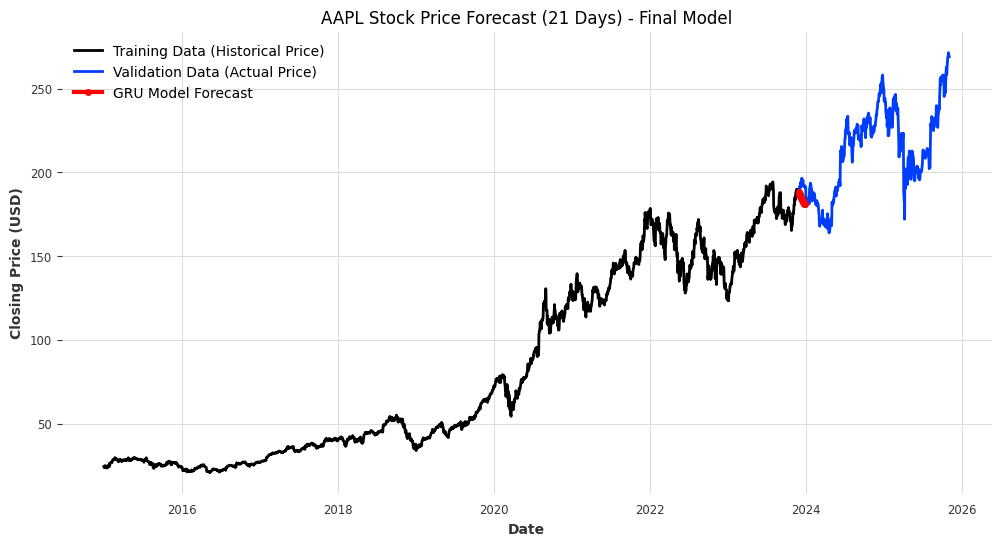

In [5]:
# 6. Evaluate Metrics
forecast_1d = forecast_1m[:1]
forecast_1w = forecast_1m[:5]
actual_1d = val_series[:1]
actual_1w = val_series[:5]

mape_1d = mape(actual_1d, forecast_1d)
mape_1w = mape(actual_1w, forecast_1w)
mape_1m = mape(actual_1m, forecast_1m)

print("\n--- FINAL EVALUATION (MAPE %) ---")
print(f"MAPE (1 Day Ahead): {mape_1d:.4f}%")
print(f"MAPE (1 Week Ahead): {mape_1w:.4f}%")
print(f"MAPE (1 Month Ahead): {mape_1m:.4f}%")

# 7. Visualization
plt.figure(figsize=(12, 6))

# Plot the training data and the actual validation data
train_series.plot(label='Training Data (Historical Price)', lw=2)
val_series.plot(label='Validation Data (Actual Price)', lw=2)

# Plot the forecast
forecast_1m.plot(label='GRU Model Forecast', lw=3, color='red', marker='o', markersize=4)

# Add a title and labels
plt.title(f'AAPL Stock Price Forecast (21 Days) - Final Model')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()